# 4장 - 유용한 선형회귀

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import graphviz as gr
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
style.use("ggplot")
import statsmodels.formula.api as smf
import matplotlib
from cycler import cycler

default_cycler = (cycler(color=['0.3', '0.5', '0.7', '0.5']))

color=['0.3', '0.5', '0.7', '0.9']
linestyle=['-', '--', ':', '-.']
marker=['o', 'v', 'd', 'p']

plt.rc('axes', prop_cycle=default_cycler)

gr.set_default_format("png");

In [ ]:
# 한국어 폰트 설정

# !sudo apt-get install fonts-nanum
# !fc-cache -fv
# !python --version
# !cp /usr/share/fonts/truetype/nanum/Nanum/usr/local/lib/python3/dist-packages/matplotlib/mpl-data/fonts/ttf/

from matplotlib import font_manager as fm
fe = fm.FontEntry(fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
                  name='NanumGothic')                                       # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)                                        # Matplotlib에 폰트 추가
plt.rcParams.update({'font.family': 'NanumGothic', 'font.size': 10})        # 폰트 설정
plt.rcParams['axes.unicode_minus'] = False

In [ ]:
# 구글 드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

# Path
path_drive = f"/content/drive/MyDrive/직장_YGY/Study '23 - Causal Inference/'24 Python/"

# Change Directory
import os
os.chdir(path_drive)

Mounted at /content/drive


## 4.1 선형회귀의 필요성
* 회귀분석은 인과추론의 핵심이자 가장 많이 사용되는 방법론
* 대부분의 패널데이터 방법론, 머신러닝 방법, 도구변수의 활용, 불연속 설계 등 응용 방법론의 주요 구성 요소



### 4.1.1 모델이 필요한 이유
* 은행에서 신용카드 한도가 채무불이행에 미치는 영향을 알아보는 예제
    * 기대 : 신용카드 한도를 늘리면 카드 대금을 미납할 확률이 높아질 것 (양의 상관관계)
    * 현실 : 데이터를 살펴보면 신용한도와 채무불이행 사이 음의 상관관계 도출
    * 원인 : 은행과 대출 회사에서 심사 모델에 따라 채무불이행 가능성(위험도)이 낮은 고객에게 더 높은 신용 한도를 설정하기 때문.
      * 위험도라는 '교란편향'으로 인한 음의 상관관계 발생
    * 해결 : 소득이나 신용점수 같은 '대리변수'를 사용하여 위험도 추정 가능

* 정리
  * 앞장에서 봤던 조건부 독립성 가정이 만족되면 인과효과를 식별할 수 있으나 (T=1,0 상태에서의 ATE 직접 산출)
  * 지금 예시처럼 조건부를 설정할 변수가 연속형이거나 변수의 수가 많을수록 차원의 저주에 걸릴 수 있음
  * 이를 해결하기 위해 잠재적 결과를 선형회귀 같은 방식으로 모델링할 수 있음
* 선형회귀 a.k.a 차원축소알고리즘
  * Why? 결과변수를 X 변수가 존재하는 공간에 투영한 후, 투영된 값들을 바탕으로 실험군과 대조군을 비교


In [ ]:
risk_data = pd.read_csv("./data/risk_data.csv")

risk_data.head()

,wage,educ,exper,married,credit_score1,credit_score2,credit_limit,default
0,950.0,11,16,1,500.0,518.0,3200.0,0
1,780.0,11,7,1,414.0,429.0,1700.0,0
2,1230.0,14,9,1,586.0,571.0,4200.0,0
3,1040.0,15,8,1,379.0,411.0,1500.0,0
4,1000.0,16,1,1,379.0,518.0,1800.0,0


In [ ]:
risk_data['credit_limit'].corr(risk_data['default'])

-0.09213138427841128

In [ ]:
(risk_data
 .groupby("default")
 ["credit_limit"]
 .mean())

,credit_limit
default,
0,2901.860575
1,2548.474801


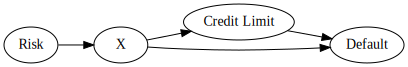

In [23]:
g_risk = gr.Digraph(graph_attr={"rankdir":"LR"})

g_risk.edge("Risk", "X")
g_risk.edge("X", "Credit Limit")
g_risk.edge("X", "Default")
g_risk.edge("Credit Limit", "Default")

g_risk

### 4.1.2 A/B 테스트와 회귀분석
* 온라인 스트리밍 기업에서 추천 시스템을 개선하는 상황을 가정해보자
    * 새로운 추천 시스템이 스트리밍 서비스의 시청 시간을 늘릴 수 있는지를 시험해보고자 함
* 이때 A/B 테스트 결과를 회귀분석으로 해석하면 필요한 추론 통계량 (표준오차, 신뢰구간)을 바로 구할 수 있다.

  * $WahtchTime_i = \beta_0 + \beta_{1}challenger_{i}+e_i$

  * 새로운 버전의 효과는 $\beta_{1}$의 추정값인 $\hat{\beta_{1}}$ 이 된다.

In [ ]:
import pandas as pd
import numpy as np

data = pd.read_csv("./data/rec_ab_test.csv")
data.head()

,recommender,age,tenure,watch_time
0,challenger,15,1,2.39
1,challenger,27,1,2.32
2,benchmark,17,0,2.74
3,benchmark,34,1,1.92
4,benchmark,14,1,2.47


In [ ]:
(data
 .groupby("recommender")
 ["watch_time"]
 .mean())

,watch_time
recommender,
benchmark,2.049064
challenger,2.191750


In [ ]:
print(f" 조건부 독립성 가정을 만족했을 때의 ATE: {round(2.191750-2.049064,4)}")

 조건부 독립성 가정을 만족했을 때의 ATE: 0.1427


* 회귀분석으로 통계적 유의성을 검증해보자

In [ ]:
import statsmodels.formula.api as smf

result = smf.ols('watch_time ~ C(recommender)', data=data).fit() #C:범주형변수표기

result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.0491,0.058,35.367,0.000,1.935,2.163
C(recommender)[T.challenger],0.1427,0.095,1.501,0.134,-0.044,0.330


* 절편항 : 기존 버전의 추천 시스템을 사용했을 경우 평균적인 스트리밍 시간은 2.04 시간
* 베타 : 새로운 버전 사용에 따른 시청 시간 증가 효과로 0.14 시간 만큼의 효과가 있다고 할 수 있다. 하지만 이는 통계적으로 유의하지 않다.

### 4.1.3 회귀분석을 통한 보정 (교란요인 추가)
* 다시 '신용한도'와 '채무불이행' 간의 관계 예시로 돌아옴
  * $Default_i = \beta_0 + \beta_{1}line_{i} + e_i$

  * 원인변수(신용한도)를 범주형이 아닌 연속형 변수로 처리하면, 기대 결과의 처치에 대한 도함수(derivative)로 표현됨
  * 즉, $\beta_1$은 신용한도가 1달러 증가했을 때 채무불이행률이 얼마나 변할 것인지에 대한 기댓값을 나타낸다.

* 교란 변수를 처리하기 위해서는 회귀분석 모형에 단순히 교란요인들을 추가만 하면 된다. (OLS 추정)

  * $Default_i = \beta_0 + \beta_{1}line_{i} + \theta_{}X_{i}+ e_i$
  
  * $\beta_1$은 신용한도에 대한 채무불이행률 기댓값의 '편도함수'라고 볼 수 있다.
  
  * 직관적으로 모델의 '다른 변수들이 고정된 상태에서' 신용 한도를 조금 늘렸을 때 채무불이행률이 얼마나 변할지에 대한 기댓값이다.

In [ ]:
risk_data = pd.read_csv("./data/risk_data.csv")

risk_data.head()

,wage,educ,exper,married,credit_score1,credit_score2,credit_limit,default
0,950.0,11,16,1,500.0,518.0,3200.0,0
1,780.0,11,7,1,414.0,429.0,1700.0,0
2,1230.0,14,9,1,586.0,571.0,4200.0,0
3,1040.0,15,8,1,379.0,411.0,1500.0,0
4,1000.0,16,1,1,379.0,518.0,1800.0,0


In [ ]:
model = smf.ols('default ~ credit_limit', data=risk_data).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2192,0.004,59.715,0.000,0.212,0.226
credit_limit,-2.402e-05,1.16e-06,-20.689,0.000,-2.63e-05,-2.17e-05


* 신용한도가 1달러 증가했을 때 채무불이행률은 음의 방향으로 떨어짐
* 이는 은행과 대출 회사에서 심사 모델에 따라 채무불이행 가능성이 낮은 고객에게 더 높은 신용 한도를 설정하기 때문이다.

Text(0.5, 1.0, 'Default Rate by Credit Limit')

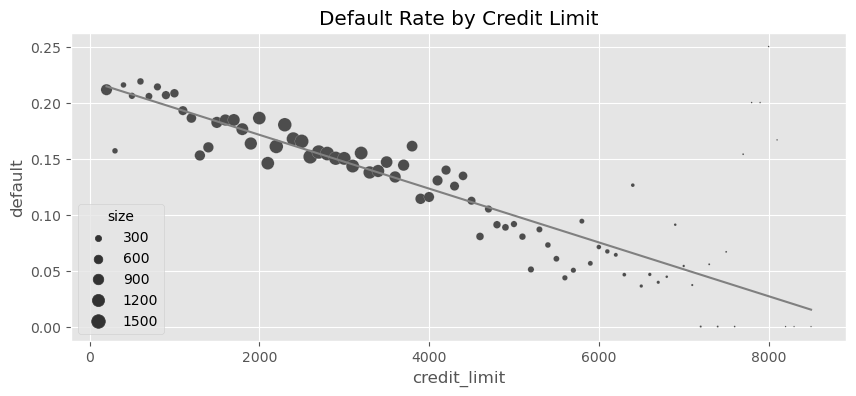

In [ ]:
plt_df = (risk_data
          .assign(size=1)
          .groupby("credit_limit")
          .agg({"default": "mean", "size":sum})
          .reset_index()
          .assign(prediction = lambda d: model.predict(d)))

plt.figure(figsize=(10,4))

sns.scatterplot(data=plt_df,
                x="credit_limit",
                y="default",
                size="size",
                sizes=(1,100))

plt.plot(plt_df["credit_limit"], plt_df["prediction"], color="C1")
plt.title("Default Rate by Credit Limit")


* 편향을 보정하려면
  * 이론적으로는
    * (1)교란요인을 기준으로 데이터를 나누고 (2)나눈 그룹 내에서 회귀모델을 만들고 (3)기울기 매개변수 추출을 통해 결과의 평균을 구함
    * 문제 : 그룹을 나누게 되면 표본이 하나뿐이거나 표본이 없는 그룹이 존재함. 하나 이하의 표본으로는 회귀할 수가 없음. -> 차원의 저주
  * OLS 추정 모델에 교란요인을 추가하면 끝!

In [ ]:
risk_data.groupby(["credit_score1", "credit_score2"]).size().head() #두 가지 신용점수라는 교란요인으로 그룹을 나눔, 표본 없는 그룹 존재

credit_score1  credit_score2
34.0           339.0            1
               500.0            1
52.0           518.0            1
69.0           214.0            1
               357.0            1
dtype: int64

In [ ]:
formula = 'default ~ credit_limit + wage + credit_score1 + credit_score2' #회귀모델에 교란요인 추가
model = smf.ols(formula, data=risk_data).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.4037,0.009,46.939,0.000,0.387,0.421
credit_limit,3.063e-06,1.54e-06,1.987,0.047,4.16e-08,6.08e-06
wage,-8.822e-05,6.07e-06,-14.541,0.000,-0.000,-7.63e-05
credit_score1,-4.175e-05,1.83e-05,-2.278,0.023,-7.77e-05,-5.82e-06
credit_score2,-0.0003,1.52e-05,-20.055,0.000,-0.000,-0.000


* 신용한도와 채무불이행률 사이의 관계가 양수로 바뀜 (신용한도를 1단위씩 늘릴수록 채무불이행률 증가)

* 다중회귀가 아닌 "프리슈-워-로벨(FWL) 정리" 라는 것을 활용해서 편향 제거도 가능
  * 용도 : 편향 제거 단계와 영향 추정 단계 분리
  * 예 : 신용한도라는 원인변수(Treatment)도 편향이 있을 수 있음. 이때 FWL 정리를 사용하면, 전처리 단계에서 편향을 제거할 수 있음. 이후에 배울 예정

## 4.2 회귀분석 이론
* 매개변수 벡터를 $\beta^{*}$ 라 할 때 아래와 같이 정의할 수 있다.
  * $\beta^{*} = \underset{\beta}{argmin}E[{(Y_i - X_i^{`}\beta)}^2]$
* 선형회귀분석은 평균제곱오차를 최소화하는 매개변수를 찾는다. 이를 미분하고 그 결과를 0 으로 두면 선형 해는 아래와 같다.
  * $\beta^{*} = E{[X^{`}X]}^{-1}E[X^{`}Y]$

In [ ]:
X_cols = ["credit_limit", "wage", "credit_score1", "credit_score2"]
X = risk_data[X_cols].assign(intercep=1) #마지막 변수로 절편 추가
y = risk_data["default"]

def regress(y, X):
    return np.linalg.inv(X.T.dot(X)).dot(X.T.dot(y)) #선형 해(beta) 직접 계산

beta = regress(y, X)
beta

array([ 3.06252773e-06, -8.82159125e-05, -4.17472814e-05, -3.03928359e-04,
        4.03661277e-01])

### 4.2.1 단순선형회귀
* 인과추론에서는 변수 T가 결과 Y에 미치는 인과효과를 추정하려는 경우가 많다.
* 단일 설명변수 T를 사용할 때 T의 효과는 아래와 같이 계산할 수 있다.
  * 처치효과 = 공분산(두 변수 간 관계의 방향과 강도) / 분산(처치에 따른 변화 정도) = 선형회귀의 기울기
  * $\hat{\tau} = \frac{Cov(Y_i, T_i)}{Var(T_i)} = \frac{E[(T_i-\bar{T})(Y_i - \bar{Y})]}{E[(T_i - \bar{T})^2]}$
* 회귀분석은 처치와 결과가 어떻게 함께 움직이는지를 파악하고 이를 처치 대상에 따라 조정한다.

### 4.2.2 다중선형회귀
* 다중선형회귀의 경우 단순선형회귀분석을 확장하기만 하면 된다.
* 다른 변수는 보조적인 변수들이고 T와 관련된 $\tau$ 를 추정하는 것으로 생각하면 아래와 같이 정리할 수 있다.
    * $\hat{\tau} = \frac{Cov(Y_i, \tilde{T_i})}{Var(\tilde{T_i})}$
    * $\tilde{T_i}$ 는 $T_i$ 를 모든 공변량 $X_{1i} + ...  + X_{ki}$ 에 대해 회귀한 잔차이다.
    * 다시 말해, 다중회귀분석의 회귀계수는 **모델의 다른 변수들의 효과를 고려한 후** 얻은 동일 설명변수의 이변량 계수라는 의미. (두 개 변수만 사용한 bivariate regression의 계수)
* 직관적으로 보면, 다른 변수를 사용해 T를 예측할 수 있다면 T는 무작위가 아니다. 그러나 **모든 교란 요인 X를 통제하면** T를 무작위로 보이게 할 수 있다. -> FWL 정리의 개념과 같음

## 4.3 프리슈-워-로벨 정리와 직교화

>*FWL : 교란을 통제하여, 처치가 무작위 배정된 것처럼 보이게 만드는 편향 제거(debiasing) 기법*

>*직교화 : 편향 제거 단계를 직교화(orthogonalization)라고 부르기도 하고 잔차화(residualization)라고도 함*

* FWL 정리의 원리
  * 회귀식의 잔차 (Residual = $Y - \hat{Y}$) 활용
    * 실제값과 예측값의 차이. 즉, 결과변수 $Y$가 가진 순수 변동성
    * 다시 말해 '원인변수 $X$의 효과가 제거된' 또는 '$X$로 인한 편향이 없을 때'의 결과

* FWL 정리에 따른 인과 추론 과정
  0. 상황 : 다중선형관계 $Y$ ~ $T, X$ 에서 교란 $X$로 인한 편향 제거 후, 처치 $T$가 결과 $Y$에 미치는 인과 효과 규명
  1. 편향 제거 단계 : $T$를 $X$에 회귀해 **처지잔차** $\tilde{T}$ $(= T - \hat{T})$ 를 구한다.
  2. 잡음 제거 단계 : $Y$를 $X$에 회귀해 **결과잔차** $\tilde{Y}$ $(= Y - \hat{Y})$ 를 구한다.
  3. 결과 모델 단계 : 결과잔차 $\tilde{Y}$를 처치잔차 $\tilde{T}$에 대해 회귀해 $T$가 $Y$에 미치는 인과효과 추정값을 구한다.
  
* FWL 정리 단계별 효과
  1. 교란과 처치변수를 상관없게 만듦
  2. 교란으로 인한 결과변수의 분산 감소
  3. 처치로 인한 순변동분 만을 활용한 인과추론

* 결론
  * 쎄가 빠지게 FWL 1~3단계로 구한 결과 = 다중선형회귀로 구한 결과
  * FWL은 참고만 하고 "다중회귀분석 쓰면 됩니다~"

In [ ]:
# 0. 상황
y = 'default'
t = 'credit_limit'
x = 'wage'

# 1. 편향 제거 단계
formula = f'{t} ~ {x}'
t_model = smf.ols(formula, data=risk_data).fit()
t_resid = t_model.resid

# 2. 잡음 제거 단계
formula = f'{y} ~ {x}'
y_model = smf.ols(formula, data=risk_data).fit()
y_resid = y_model.resid

# 3. 결과 모델 단계
formula = f'y_resid ~ t_resid'
model = smf.ols(formula,
                data=pd.DataFrame({'t_resid':t_resid, 'y_resid':y_resid})).fit()

print(t_model.summary().tables[1])
print(t_resid.head(),'\n')
print(y_model.summary().tables[1])
print(y_resid.head(),'\n')
print(model.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    530.3769     12.797     41.445      0.000     505.294     555.460
wage           2.1838      0.011    194.332      0.000       2.162       2.206
0     594.968272
1    -533.777705
2     983.491056
3   -1301.577976
4    -914.224088
dtype: float64 

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2872      0.004     65.685      0.000       0.279       0.296
wage          -0.0001   3.84e-06    -33.460      0.000      -0.000      -0.000
0   -0.165125
1   -0.186961
2   -0.129158
3   -0.153564
4   -0.158702
dtype: float64 

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.106e-16

* FWL 정리에 따라, $X$의 편향과 잡음을 제거한 뒤, $T$가 $Y$에 미치는 효과 산출
  * coef = 2.265e-06 (p-value = 0.138)

In [ ]:
formula = 'default ~ credit_limit + wage'
model = smf.ols(formula, data=risk_data).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2860,0.004,64.316,0.000,0.277,0.295
credit_limit,2.265e-06,1.53e-06,1.483,0.138,-7.29e-07,5.26e-06
wage,-0.0001,5.09e-06,-26.228,0.000,-0.000,-0.000


* 다중선형회귀를 사용하여, $X$가 존재할 때(통제할 때), $T$가 $Y$에 미치는 효과 산출
  * coef = 2.265e-06 (p-value = 0.138)

> *결론 : 다중선형회귀를 사용하면 (FWL 정리가 반영되어) 교란변수 $X$로 인한 편향과 잡음이 제거된다.*

### 4.3.1 편향 제거 단계
* FWL 정리에 따르면, 교란 요인으로부터 처치인 신용 한도를 예측하는 회귀 모델을 적합시켜 데이터의 편향을 제거할 수 있다.
* 이 때 구해진 '잔차'는 편향 제거 모델에 사용된 변수와는 상관관계가 없는 버전의 처치로 간주할 수 있다. (예측값을 생성한 변수와 직교하기 때문)

Text(0.5, 1.0, 'Default Rate by Credit Limit (편향 제거 전)')

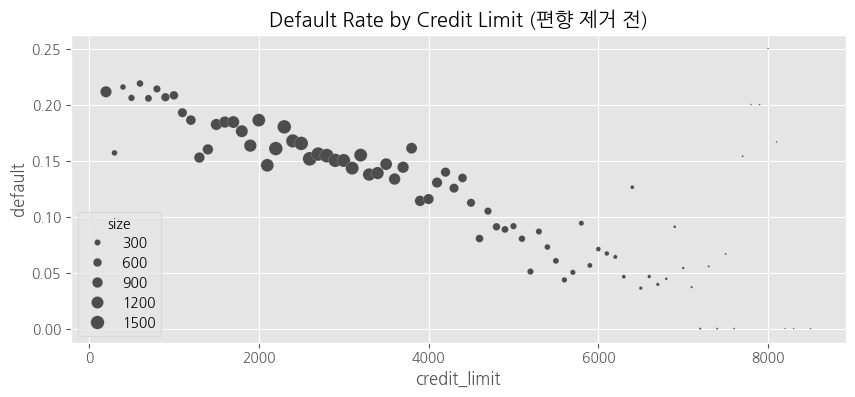

In [ ]:
plt_df = (risk_data
          .assign(size=1)
          .groupby("credit_limit")
          .agg({"default": "mean", "size":sum})
          .reset_index())

plt.figure(figsize=(10,4))
sns.scatterplot(data=plt_df,
                x="credit_limit",
                y="default",
                size="size",
                sizes=(1,100))


plt.title("Default Rate by Credit Limit (편향 제거 전)")


* 처음에는 교란편향의 영향으로 우하향 추세를 보임 -> FWL 정리에 따른 편향 제거 모델 개발

In [ ]:
## 편향 제거 모델 (t ~ X)
debiasing_model = smf.ols(
    'credit_limit ~ wage + credit_score1  + credit_score2',
    data=risk_data
).fit()

risk_data_deb = risk_data.assign(
    # for visualization, avg(T) is added to the residuals
    credit_limit_res=(debiasing_model.resid
                      + risk_data["credit_limit"].mean()) #잔차를 처치변수에 반영 (편향제거)
)
risk_data_deb.head()

,wage,educ,exper,married,credit_score1,credit_score2,credit_limit,default,credit_limit_res
0,950.0,11,16,1,500.0,518.0,3200.0,0,3347.583906
1,780.0,11,7,1,414.0,429.0,1700.0,0,2331.086567
2,1230.0,14,9,1,586.0,571.0,4200.0,0,3665.134174
3,1040.0,15,8,1,379.0,411.0,1500.0,0,1720.933260
4,1000.0,16,1,1,379.0,518.0,1800.0,0,2084.659827


In [ ]:
## 편향 제거된 처치변수로 인과효과 추정
model_w_deb_data = smf.ols('default ~ credit_limit_res',
                           data=risk_data_deb).fit()

## (참고) full model
full_model = smf.ols('default ~ credit_limit + wage+credit_score1+credit_score2',
                     data=risk_data_deb).fit()

print('편향 제거 모델')
print(model_w_deb_data.summary().tables[1],'\n')

print('Full 모델')
print(full_model.summary().tables[1])

편향 제거 모델
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.1421      0.005     30.001      0.000       0.133       0.151
credit_limit_res  3.063e-06   1.56e-06      1.957      0.050   -4.29e-09    6.13e-06

Full 모델
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.4037      0.009     46.939      0.000       0.387       0.421
credit_limit   3.063e-06   1.54e-06      1.987      0.047    4.16e-08    6.08e-06
wage          -8.822e-05   6.07e-06    -14.541      0.000      -0.000   -7.63e-05
credit_score1 -4.175e-05   1.83e-05     -2.278      0.023   -7.77e-05   -5.82e-06
credit_score2    -0.0003   1.52e-05    -20.055      0.000      -0.000      -0.000


* Full model 과 차이가 있다면 p값이 약간 높다는 점이다 (full model 이 더 좋음).
* 이는 분산 감소를 담당하는 '잡음 제거 단계'를 거치지 않았기 때문이다. 잔차와 결과 변수 간의 관계를 시각화 하면 아래와 같다.

Text(0.5, 1.0, 'Default Rate by Debiased Credit Limit (편향 제거 후)')

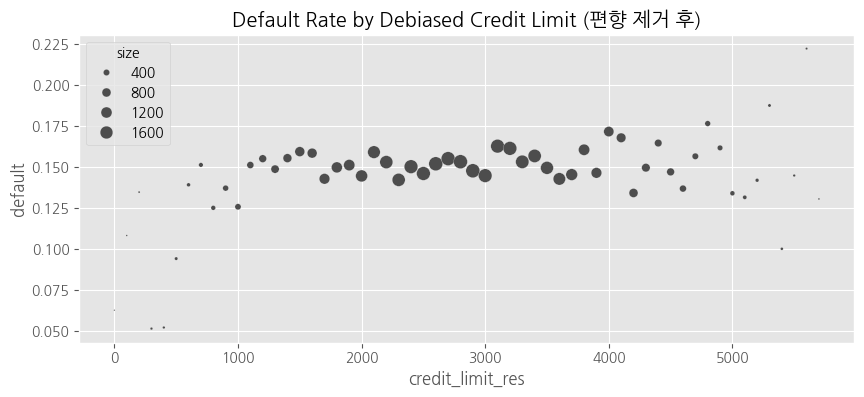

In [ ]:
plt_df = (risk_data_deb
          .assign(size=1)
          .assign(credit_limit_res = lambda d: d["credit_limit_res"].round(-2))
          .groupby("credit_limit_res")
          .agg({"default": "mean", "size":sum})
          .query("size>30")
          .reset_index())

plt.figure(figsize=(10,4))
sns.scatterplot(data=plt_df,
                x="credit_limit_res",
                y="default",
                size="size",
                sizes=(1,100))

plt.title("Default Rate by Debiased Credit Limit (편향 제거 후)")


### 4.3.2 잡음 제거 단계
* 잡음을 제거한다고 처치 효과의 추정값이 바뀌지는 않지만 "분산을 줄일 수 있는 효과"를 가진다.
* 이 단계에서는 결과를 처치가 아닌 공변량 X에 대해 회귀한다.

In [ ]:
## 잡음 제거 모델 (y ~ X)
denoising_model = smf.ols(
    'default ~ wage + credit_score1  + credit_score2',
    data=risk_data_deb
).fit()

risk_data_denoise = risk_data_deb.assign(
    default_res=denoising_model.resid + risk_data_deb["default"].mean() #잔차를 결과변수에 반영 (분산감소)
)
risk_data_denoise.head()

,wage,educ,exper,married,credit_score1,credit_score2,credit_limit,default,credit_limit_res,default_res
0,950.0,11,16,1,500.0,518.0,3200.0,0,3347.583906,0.000981
1,780.0,11,7,1,414.0,429.0,1700.0,0,2331.086567,-0.043175
2,1230.0,14,9,1,586.0,571.0,4200.0,0,3665.134174,0.043289
3,1040.0,15,8,1,379.0,411.0,1500.0,0,1720.933260,-0.028427
4,1000.0,16,1,1,379.0,518.0,1800.0,0,2084.659827,0.000760


### 4.3.3 회귀 추정량의 표준오차
* 잡음 관련해서는 회귀 표준오차 계산법을 살펴본다.
* 추정한 회귀계수의 표준오차 공식은 아래와 같다.
  * $SE(\hat{\beta}) = \frac{\sigma(\hat{\epsilon})}{\sigma(\tilde{T})\sqrt{n-DF}}$
* 분자는 결과를 잘 예측할수록 잔차가 작아지므로 추정값의 분산이 낮아진다.
  * 처치가 결과를 많이 설명하면 추정값의 표준오차도 작아진다.
* 오차는 (잔차화된) 처치의 분산에 반비례한다.

In [ ]:
## 표준오차 계산방법 1
model_se = smf.ols(
    'default ~ wage + credit_score1  + credit_score2', #y ~ X
    data=risk_data
).fit()

print("SE regression:", model_se.bse["wage"]) #x1 표준오차


## 표준오차 계산방법 2
model_wage_aux = smf.ols(
    'wage ~ credit_score1 + credit_score2', #x1 ~ x2
    data=risk_data
).fit()

# subtract the degrees of freedom - 4 model parameters - from N.
se_formula = (np.std(model_se.resid)
              /(np.std(model_wage_aux.resid)*np.sqrt(len(risk_data)-4)))

print("SE formula:   ", se_formula) #x1 표준편차

SE regression: 5.364242347548204e-06
SE formula:    5.364242347548193e-06


### 4.3.4 최종 결과 모델
* 마지막으로 두 잔차를 이용해 회귀를 진행하면 full model 에서 얻었던 결과와 동일한 결과를 얻게 된다.

In [ ]:
model_w_orthogonal = smf.ols('default_res ~ credit_limit_res',
                             data=risk_data_denoise).fit()

model_w_orthogonal.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1421,0.005,30.458,0.000,0.133,0.151
credit_limit_res,3.063e-06,1.54e-06,1.987,0.047,4.17e-08,6.08e-06


Text(0.5, 1.0, 'Denoised Default Rate by Debiased Credit Limit (FWL 정리 반영 후)')

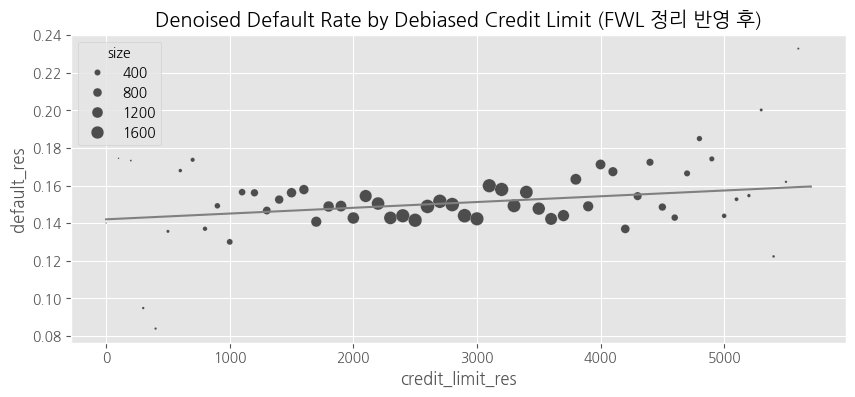

In [ ]:
plt_df = (risk_data_denoise
          .assign(size=1)
          .assign(credit_limit_res = lambda d: d["credit_limit_res"].round(-2))
          .groupby("credit_limit_res")
          .agg({"default_res": "mean", "size":sum})
          .query("size>30")
          .reset_index()
          .assign(prediction = lambda d: model_w_orthogonal.predict(d)))

plt.figure(figsize=(10,4))
sns.scatterplot(data=plt_df,
                x="credit_limit_res",
                y="default_res",
                size="size",
                sizes=(1,100))

plt.plot(plt_df["credit_limit_res"], plt_df["prediction"], c="C1")

plt.title("Denoised Default Rate by Debiased Credit Limit (FWL 정리 반영 후)")



## 4.3.5 FWL 정리 요약
* 처치 T와 결과 Y 사이의 관계를 추정하고 싶지만 교란요인 X가 있을 때 FWL 정리 사용
* 1. 편향 제거 : 편향이 제거된 처치를 얻을 수 있으나 여전히 잡음이 많음
* 2. 잡음 제거 : 교란으로 인한 분산이 줄어들어, 처치와 결과의 관계를 더 쉽게 파악할 수 있음
* 3. 인과추론 : 편향과 잡음 제거 후, 처치와 결과로 회귀 적합

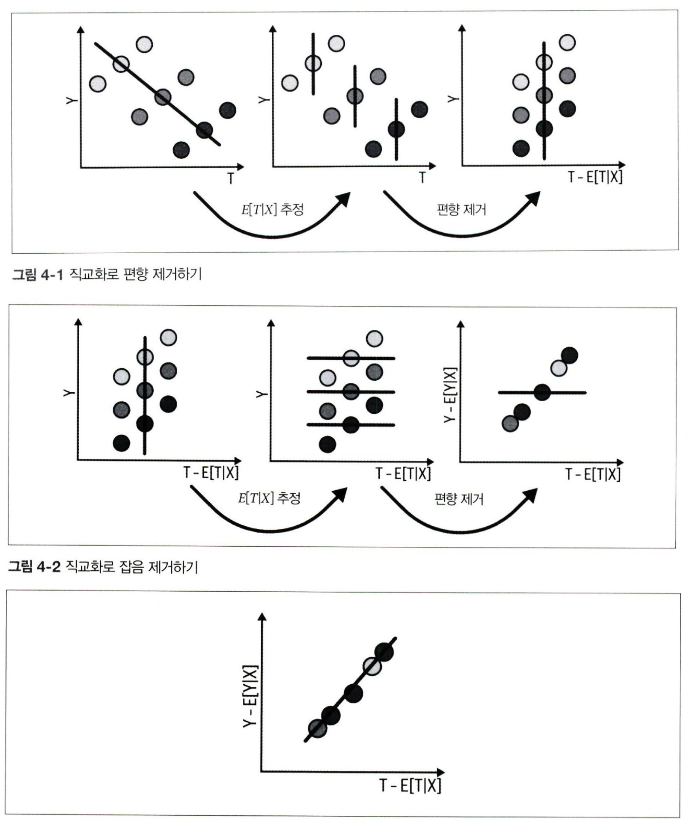

## 4.4 결과 모델으로서의 회귀분석
* 회귀분석은 잠재적 결과를 대체하는 방법으로도 볼 수 있다.
* 대조군 (T=0) 에서 X에 대한 Y의 회귀 분석이 $E[Y_0|X]$를 아주 잘 근사한다면(=X-Y 관계가 명확하면) 해당 모델을 이용해 ATT를 추정할 수 있다.
    * $ATT = \frac{1}{N_{1}}\sum{1(T_i=1)(Y_i- \hat{\mu_0}(X_i))}$
      * $ATT$ : 실험군 내에서 처치를 실제로 받았을 때의 평균 처치 효과
      * $N_{1}$은 실험군 대상자수, 1(.)은 지시함수로 인수가 참이면 1, 아니면 0 반환
* 마찬가지로 실험군에서도 X에 대한 Y의 회귀분석이 잘 모델링된다면, 대조군에서의 평균 효과를 추정할 수 있다.
    * $ATE = \frac{1}{N}\sum{\hat{\mu_1}(X_i) - \hat{\mu_0}(X_i)}$
      * $ATE$ : 전체 모집단(실험군과 대조군)에서의 평균 처치 효과
      * 이 추정량은 Y를 X와 T 모두에 회귀하고, T에 대한 매개변수 추정값을 얻는 것과 동일 (앞선 FWL 과정에서 정리로 확인)
* $E[T|X]$를 정확하게 추정하여 직교화할 수 있거나 잠재적 결과 $E[Y_t|X]$를 정확하게 추정할 수 있다는 사실은 회귀분석이 이중 강건하다는 특성을 나타낸다. -> 5장에서 깊이 다룰 예정

* Example. 사립학교 재학이 개인소득에 미치는 영향
  * 회귀식에 어떤 변수를 넣어 통제하느냐에 따라 결과가 달라짐
    * y(소득) ~ x(사립학교) : 양의 관계
    * y(소득) ~ X(사립학교, SAT점수, 부모소득) : 약한 양의 관계
    * y(소득) ~ X(사립학교, SAT점수, 부모소득, 지원대학의 평균SAT점수) : 통계적으로 유의하지 않음
    * y(소득) ~ X(사립학교, 지원대학의 평균SAT점수) : 통계적으로 유의하지 않음
  * 결론 : 학생들의 포부 수준(지원대학)을 고려하면, 사립학교에 다니는 것이 적어도 소득 측면에서는 중요하지 않음

## 4.5 양수성과 외삽
- 회귀분석은 잠재적 결과를 모수적으로 모델링하므로 데이터의 처치 범위 외의 범위에 대해서도 외삽을 할 수 있다. 단, 외삽은 데이터에 따라 합리적일수도 있고 그렇지 않을수도 있다.

Text(0.5, 1.0, 'Dataset 2')

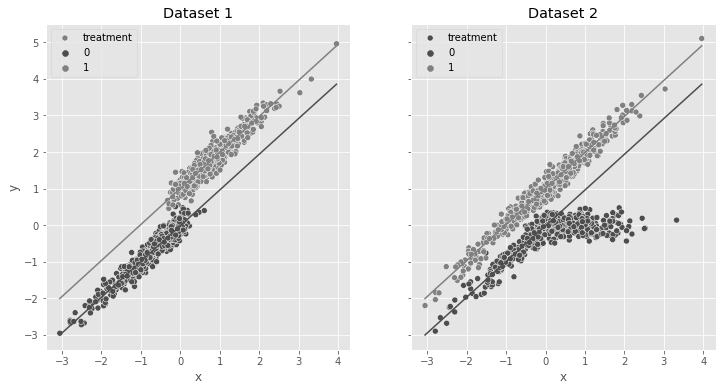

In [ ]:
np.random.seed(1)

n = 1000
x = np.random.normal(0, 1, n)
t = np.random.normal(x, 0.2, n) > 0

y0 = x
y1 = 1 + x

y = np.random.normal((1-t)*y0 + t*y1, 0.2)

df_no_pos = pd.DataFrame(dict(x=x,t=t.astype(int),y=y))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

sns.scatterplot(data=df_no_pos, x="x", y="y", hue="t", ax=ax1, label="treatment")

m0 = smf.ols("y~x", data=df_no_pos.query(f"t==0")).fit()
m1 = smf.ols("y~x", data=df_no_pos.query(f"t==1")).fit()

sns.lineplot(data=df_no_pos.assign(pred=m0.predict(df_no_pos)), x="x", y="pred", color=f"C0", ax=ax1)
sns.lineplot(data=df_no_pos.assign(pred=m1.predict(df_no_pos)), x="x", y="pred", color=f"C1", ax=ax1);
ax1.set_title("Dataset 1")

np.random.seed(1)

n = 1000
x = np.random.normal(0, 1, n)
t = np.random.binomial(1, 0.5, size=n)

y0 = x * (x<0) + (x>0)*0
y1 = 1 + x

y = np.random.normal((1-t)*y0 + t*y1, 0.2)

df_pos = pd.DataFrame(dict(x=x,t=t.astype(int),y=y))

sns.scatterplot(data=df_pos, x="x", hue="t", y="y", ax=ax2, label="treatment")

sns.lineplot(data=df_no_pos.assign(pred=m0.predict(df_pos)), x="x", y="pred", color=f"C0", ax=ax2)
sns.lineplot(data=df_no_pos.assign(pred=m1.predict(df_pos)), x="x", y="pred", color=f"C1", ax=ax2)
ax2.set_title("Dataset 2")



## 4.6 선형회귀에서의 비선형성


In [ ]:
spend_data = pd.read_csv("./data/spend_data.csv")

spend_data.head()

,wage,educ,exper,married,credit_score1,credit_score2,credit_limit,spend
0,950.0,11,16,1,500.0,518.0,3200.0,3848
1,780.0,11,7,1,414.0,429.0,1700.0,3144
2,1230.0,14,9,1,586.0,571.0,4200.0,4486
3,1040.0,15,8,1,379.0,411.0,1500.0,3327
4,1000.0,16,1,1,379.0,518.0,1800.0,3508


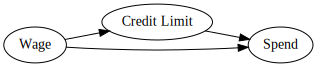

In [ ]:
g_risk = gr.Digraph(graph_attr={"rankdir":"LR"})

g_risk.edge("Wage", "Credit Limit")
g_risk.edge("Wage", "Spend")
g_risk.edge("Credit Limit", "Spend")

g_risk

<AxesSubplot:xlabel='credit_limit', ylabel='spend'>

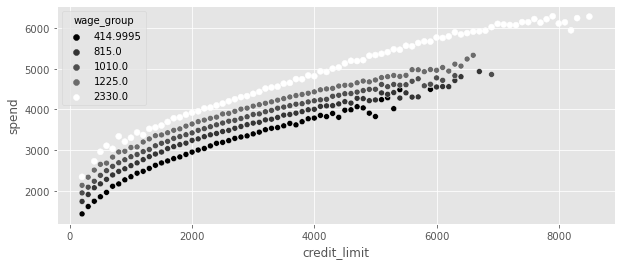

In [ ]:
plt_df = (spend_data
          .assign(wage_group = lambda d: pd.IntervalIndex(pd.qcut(d["wage"], 5)).mid)
          .groupby(["wage_group", "credit_limit"])
          [["spend"]]
          .mean()
          .reset_index())

plt.figure(figsize=(10,4))
sns.scatterplot(data=plt_df,
                x="credit_limit",
                y="spend",
                hue="wage_group",
                palette="gray")


### 4.6.1 처치 선형화

<AxesSubplot:xlabel='credit_limit_sqrt', ylabel='spend'>

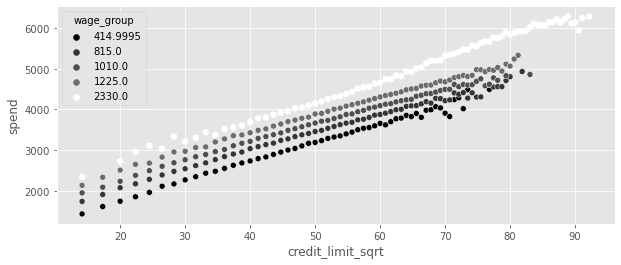

In [ ]:
plt_df = (spend_data
          # apply the sqrt function to the treatment
          .assign(credit_limit_sqrt = np.sqrt(spend_data["credit_limit"]))
          # create 5 wage binds for better vizualization
          .assign(wage_group = pd.IntervalIndex(pd.qcut(spend_data["wage"], 5)).mid)
          .groupby(["wage_group", "credit_limit_sqrt"])
          [["spend"]]
          .mean()
          .reset_index())

plt.figure(figsize=(10,4))
sns.scatterplot(data=plt_df,
                x="credit_limit_sqrt",
                y="spend",
                palette="gray",
                hue="wage_group")


In [ ]:
model_spend = smf.ols(
    'spend ~ np.sqrt(credit_limit)',data=spend_data
).fit()

model_spend.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,493.0044,6.501,75.832,0.000,480.262,505.747
np.sqrt(credit_limit),63.2525,0.122,519.268,0.000,63.014,63.491


<AxesSubplot:xlabel='credit_limit', ylabel='spend'>

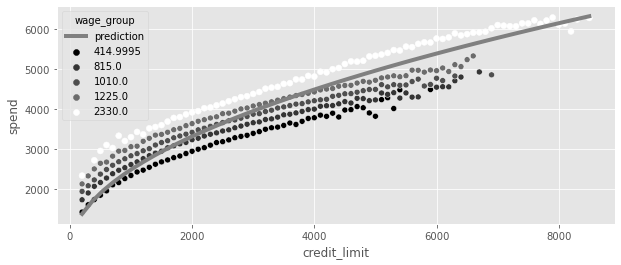

In [ ]:
plt_df = (spend_data
          .assign(wage_group = lambda d: pd.IntervalIndex(pd.qcut(d["wage"], 5)).mid)
          .groupby(["wage_group", "credit_limit"])
          [["spend"]]
          .mean()
          .reset_index()
         )

x = np.linspace(plt_df["credit_limit"].min(), plt_df["credit_limit"].max())

plt.figure(figsize=(10,4))
plt.plot(x, model_spend.params[0] + model_spend.params[1]*np.sqrt(x), color="C1", label="prediction", lw=4)
plt.legend()
sns.scatterplot(data=plt_df,
                x="credit_limit",
                y="spend",
                palette="gray",
                hue="wage_group")



In [ ]:
model_spend = smf.ols('spend ~ np.sqrt(credit_limit)+wage',
                      data=spend_data).fit()

model_spend.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,383.5002,2.746,139.662,0.000,378.118,388.882
np.sqrt(credit_limit),43.8504,0.065,672.633,0.000,43.723,43.978
wage,1.0459,0.002,481.875,0.000,1.042,1.050


### 4.6.2 비선형 FWL과 편향 제거


In [ ]:
debias_spend_model = smf.ols(f'np.sqrt(credit_limit) ~ wage',
                             data=spend_data).fit()
denoise_spend_model = smf.ols(f'spend ~ wage', data=spend_data).fit()


credit_limit_sqrt_deb = (debias_spend_model.resid
                         + np.sqrt(spend_data["credit_limit"]).mean())
spend_den = denoise_spend_model.resid + spend_data["spend"].mean()


spend_data_deb = (spend_data
                  .assign(credit_limit_sqrt_deb = credit_limit_sqrt_deb,
                          spend_den = spend_den))

final_model = smf.ols(f'spend_den ~ credit_limit_sqrt_deb',
                      data=spend_data_deb).fit()

final_model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1493.6990,3.435,434.818,0.000,1486.966,1500.432
credit_limit_sqrt_deb,43.8504,0.065,672.640,0.000,43.723,43.978


<AxesSubplot:xlabel='credit_limit', ylabel='spend'>

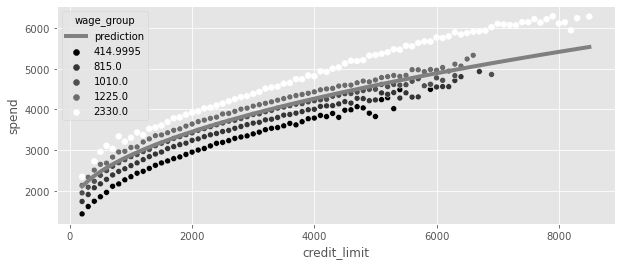

In [ ]:
plt_df = (spend_data
          .assign(wage_group = lambda d: pd.IntervalIndex(pd.qcut(d["wage"], 5)).mid)
          .groupby(["wage_group", "credit_limit"])
          [["spend"]]
          .mean()
          .reset_index())

x = np.linspace(plt_df["credit_limit"].min(), plt_df["credit_limit"].max())

plt.figure(figsize=(10,4))
plt.plot(x, (final_model.params[0]
             + final_model.params[1]*np.sqrt(x)),
         color="C1", label="prediction", lw=4)

plt.legend()

sns.scatterplot(data=plt_df,
                x="credit_limit",
                y="spend",
                palette="gray",
                hue="wage_group")


## 4.7 더미변수를 활용한 회귀분석

### 4.7.1 조건부 무작위 실험


In [ ]:
risk_data_rnd = pd.read_csv("./data/risk_data_rnd.csv")
risk_data_rnd.head()

,wage,educ,exper,married,credit_score1,credit_score2,credit_score1_buckets,credit_limit,default
0,890.0,11,16,1,490.0,500.0,400,5400.0,0
1,670.0,11,7,1,196.0,481.0,200,3800.0,0
2,1220.0,14,9,1,392.0,611.0,400,5800.0,0
3,1210.0,15,8,1,627.0,519.0,600,6500.0,0
4,900.0,16,1,1,275.0,519.0,200,2100.0,0


Text(0.5, 1.0, 'Conditional random experiment')

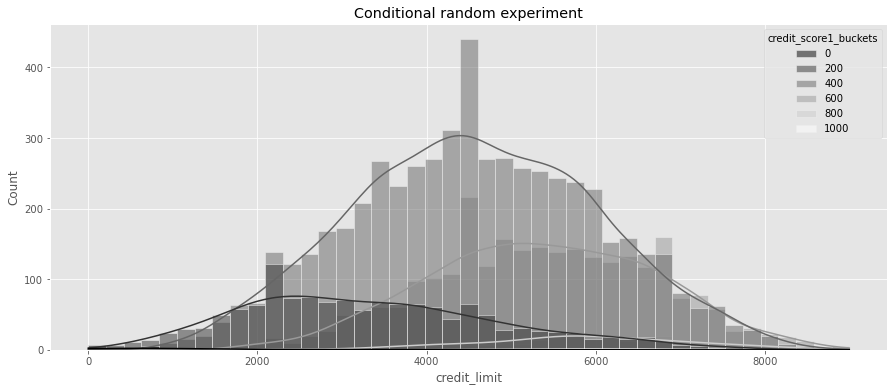

In [ ]:
plt.figure(figsize=(15,6))
sns.histplot(data=risk_data_rnd,
             x="credit_limit",
             hue="credit_score1_buckets",
             kde=True,
             palette="gray");
plt.title("Conditional random experiment")

### 4.7.2 더미변수



In [ ]:
model = smf.ols("default ~ credit_limit", data=risk_data_rnd).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1369,0.009,15.081,0.000,0.119,0.155
credit_limit,-9.344e-06,1.85e-06,-5.048,0.000,-1.3e-05,-5.72e-06


In [ ]:
pd.set_option('display.max_columns', 9)

In [ ]:
risk_data_dummies = (risk_data_rnd
                     .join(pd.get_dummies(risk_data_rnd["credit_score1_buckets"],
                                          prefix="sb",
                                          drop_first=True)))
risk_data_dummies.head()

,wage,educ,exper,married,...,sb_400,sb_600,sb_800,sb_1000
0,890.0,11,16,1,...,1,0,0,0
1,670.0,11,7,1,...,0,0,0,0
2,1220.0,14,9,1,...,1,0,0,0
3,1210.0,15,8,1,...,0,1,0,0
4,900.0,16,1,1,...,0,0,0,0


In [ ]:
model = smf.ols(
    "default ~ credit_limit + sb_200+sb_400+sb_600+sb_800+sb_1000",
    data=risk_data_dummies
).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2253,0.056,4.000,0.000,0.115,0.336
credit_limit,4.652e-06,2.02e-06,2.305,0.021,6.97e-07,8.61e-06
sb_200,-0.0559,0.057,-0.981,0.327,-0.168,0.056
sb_400,-0.1442,0.057,-2.538,0.011,-0.256,-0.033
sb_600,-0.2148,0.057,-3.756,0.000,-0.327,-0.103
sb_800,-0.2489,0.060,-4.181,0.000,-0.366,-0.132
sb_1000,-0.2541,0.094,-2.715,0.007,-0.438,-0.071


In [ ]:
model = smf.ols("default ~ credit_limit + C(credit_score1_buckets)",
                data=risk_data_rnd).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2253,0.056,4.000,0.000,0.115,0.336
C(credit_score1_buckets)[T.200],-0.0559,0.057,-0.981,0.327,-0.168,0.056
C(credit_score1_buckets)[T.400],-0.1442,0.057,-2.538,0.011,-0.256,-0.033
C(credit_score1_buckets)[T.600],-0.2148,0.057,-3.756,0.000,-0.327,-0.103
C(credit_score1_buckets)[T.800],-0.2489,0.060,-4.181,0.000,-0.366,-0.132
C(credit_score1_buckets)[T.1000],-0.2541,0.094,-2.715,0.007,-0.438,-0.071
credit_limit,4.652e-06,2.02e-06,2.305,0.021,6.97e-07,8.61e-06


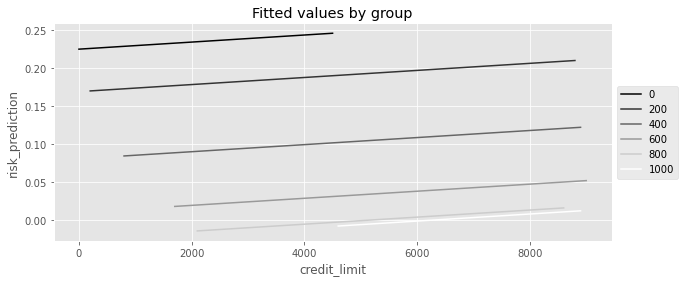

In [ ]:
plt_df = (risk_data_rnd
          .assign(risk_prediction = model.fittedvalues)
          .groupby(["credit_limit", "credit_score1_buckets"])
          ["risk_prediction"]
          .mean()
          .reset_index())

plt.figure(figsize=(10,4))
sns.lineplot(data=plt_df,
             x="credit_limit", y="risk_prediction", hue="credit_score1_buckets", palette = 'gray');
plt.title("Fitted values by group")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


### 4.7.3 포화회귀모델


In [ ]:
def regress(df, t, y):
    return smf.ols(f"{y}~{t}", data=df).fit().params[t]

effect_by_group = (risk_data_rnd
                   .groupby("credit_score1_buckets")
                   .apply(regress, y="default", t="credit_limit"))
effect_by_group

credit_score1_buckets
0      -0.000071
200     0.000007
400     0.000005
600     0.000003
800     0.000002
1000    0.000000
dtype: float64

In [ ]:
group_size = risk_data_rnd.groupby("credit_score1_buckets").size()
ate = (effect_by_group * group_size).sum() / group_size.sum()
ate

4.490445628748722e-06

In [ ]:
model = smf.ols("default ~ credit_limit * C(credit_score1_buckets)",
                data=risk_data_rnd).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.3137,0.077,4.086,0.000,0.163,0.464
C(credit_score1_buckets)[T.200],-0.1521,0.079,-1.926,0.054,-0.307,0.003
C(credit_score1_buckets)[T.400],-0.2339,0.078,-3.005,0.003,-0.386,-0.081
C(credit_score1_buckets)[T.600],-0.2957,0.080,-3.690,0.000,-0.453,-0.139
C(credit_score1_buckets)[T.800],-0.3227,0.111,-2.919,0.004,-0.539,-0.106
C(credit_score1_buckets)[T.1000],-0.3137,0.428,-0.733,0.464,-1.153,0.525
credit_limit,-7.072e-05,4.45e-05,-1.588,0.112,-0.000,1.66e-05
credit_limit:C(credit_score1_buckets)[T.200],7.769e-05,4.48e-05,1.734,0.083,-1.01e-05,0.000
credit_limit:C(credit_score1_buckets)[T.400],7.565e-05,4.46e-05,1.696,0.090,-1.18e-05,0.000
credit_limit:C(credit_score1_buckets)[T.600],7.398e-05,4.47e-05,1.655,0.098,-1.37e-05,0.000


In [ ]:
(model.params[model.params.index.str.contains("credit_limit:")]
 + model.params["credit_limit"]).round(9)

credit_limit:C(credit_score1_buckets)[T.200]     0.000007
credit_limit:C(credit_score1_buckets)[T.400]     0.000005
credit_limit:C(credit_score1_buckets)[T.600]     0.000003
credit_limit:C(credit_score1_buckets)[T.800]     0.000002
credit_limit:C(credit_score1_buckets)[T.1000]    0.000000
dtype: float64

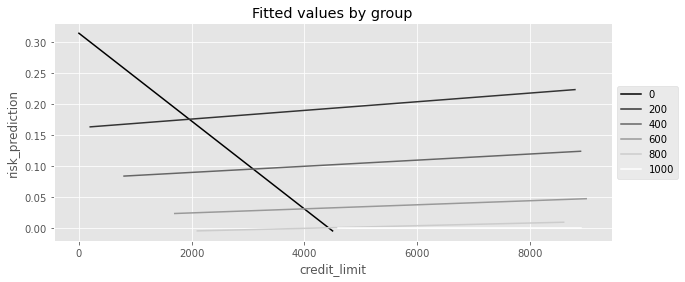

In [ ]:
plt_df = (risk_data_rnd
          .assign(risk_prediction = model.fittedvalues)
          .groupby(["credit_limit", "credit_score1_buckets"])
          ["risk_prediction"]
          .mean()
          .reset_index())

plt.figure(figsize=(10,4))
sns.lineplot(data=plt_df,
             x="credit_limit", y="risk_prediction", hue="credit_score1_buckets",  palette="gray");
plt.title("Fitted values by group")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### 4.7.4 분산의 가중평균과 회귀분석


In [ ]:
np.random.seed(123)

# std(t)=1
t1 = np.random.normal(0, 1, size=1000)
df1 = pd.DataFrame(dict(
    t=t1,
    y=1*t1, # ATE of 1
    g=1,
))

# std(t)=2
t2 = np.random.normal(0, 2, size=500)
df2 = pd.DataFrame(dict(
    t=t2,
    y=2*t2, # ATE of 2
    g=2,
))

df = pd.concat([df1, df2])
df.head()

,t,y,g
0,-1.085631,-1.085631,1
1,0.997345,0.997345,1
2,0.282978,0.282978,1
3,-1.506295,-1.506295,1
4,-0.578600,-0.578600,1


In [ ]:
effect_by_group = df.groupby("g").apply(regress, y="y", t="t")
ate = (effect_by_group *
       df.groupby("g").size()).sum() / df.groupby("g").size().sum()
ate

1.333333333333333

In [ ]:
model = smf.ols("y ~ t + C(g)", data=df).fit()
model.params

Intercept    0.024758
C(g)[T.2]    0.019860
t            1.625775
dtype: float64

### 4.7.5 평균 제거와 고정효과

In [ ]:
model_deb = smf.ols("credit_limit ~ C(credit_score1_buckets)",
                    data=risk_data_rnd).fit()
model_deb.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1173.0769,278.994,4.205,0.000,626.193,1719.961
C(credit_score1_buckets)[T.200],2195.4337,281.554,7.798,0.000,1643.530,2747.337
C(credit_score1_buckets)[T.400],3402.3796,279.642,12.167,0.000,2854.224,3950.535
C(credit_score1_buckets)[T.600],4191.3235,280.345,14.951,0.000,3641.790,4740.857
C(credit_score1_buckets)[T.800],4639.5105,291.400,15.921,0.000,4068.309,5210.712
C(credit_score1_buckets)[T.1000],5006.9231,461.255,10.855,0.000,4102.771,5911.076


In [ ]:
risk_data_rnd.groupby("credit_score1_buckets")["credit_limit"].mean()

credit_score1_buckets
0       1173.076923
200     3368.510638
400     4575.456498
600     5364.400448
800     5812.587413
1000    6180.000000
Name: credit_limit, dtype: float64

In [ ]:
risk_data_fe = risk_data_rnd.assign(
    credit_limit_avg = lambda d: (d
                                  .groupby("credit_score1_buckets")
                                  ["credit_limit"].transform("mean"))
)

In [ ]:
model = smf.ols("default ~ I(credit_limit-credit_limit_avg)",
                data=risk_data_fe).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.0935,0.003,32.121,0.000,0.088,0.099
I(credit_limit - credit_limit_avg),4.652e-06,2.05e-06,2.273,0.023,6.4e-07,8.66e-06


In [ ]:
model = smf.ols("default ~ credit_limit + credit_limit_avg",
                data=risk_data_fe).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.4325,0.020,21.418,0.000,0.393,0.472
credit_limit,4.652e-06,2.02e-06,2.305,0.021,6.96e-07,8.61e-06
credit_limit_avg,-7.763e-05,4.75e-06,-16.334,0.000,-8.69e-05,-6.83e-05


## 4.8 누락 변수 편향


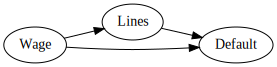

In [ ]:
g = gr.Digraph(graph_attr={"rankdir":"LR"})


g.edge("Lines", "Default")
g.edge("Wage", "Default"),
g.edge("Wage", "Lines")


g

In [ ]:
short_model = smf.ols("default ~ credit_limit", data=risk_data).fit()
short_model.params["credit_limit"]

-2.401961992596885e-05

In [ ]:
long_model = smf.ols("default ~ credit_limit + wage",
                     data=risk_data).fit()

omitted_model = smf.ols("wage ~ credit_limit", data=risk_data).fit()

(long_model.params["credit_limit"]
 + long_model.params["wage"]*omitted_model.params["credit_limit"])

-2.4019619925968762e-05

## 4.9 중립 통제변수


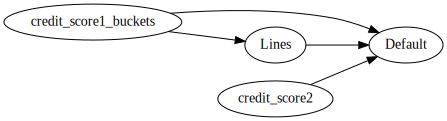

In [ ]:
g = gr.Digraph(graph_attr={"rankdir":"LR"})

g.edge("credit_score1_buckets", "Default"),
g.edge("credit_score1_buckets", "Lines"),
g.edge("credit_score2", "Default"),
g.edge("Lines", "Default")

g

In [ ]:
formula = "default~credit_limit+C(credit_score1_buckets)+credit_score2"
model = smf.ols(formula, data=risk_data_rnd).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.5576,0.055,10.132,0.000,0.450,0.665
C(credit_score1_buckets)[T.200],-0.0387,0.055,-0.710,0.478,-0.146,0.068
C(credit_score1_buckets)[T.400],-0.1032,0.054,-1.898,0.058,-0.210,0.003
C(credit_score1_buckets)[T.600],-0.1410,0.055,-2.574,0.010,-0.248,-0.034
C(credit_score1_buckets)[T.800],-0.1161,0.057,-2.031,0.042,-0.228,-0.004
C(credit_score1_buckets)[T.1000],-0.0430,0.090,-0.479,0.632,-0.219,0.133
credit_limit,4.928e-06,1.93e-06,2.551,0.011,1.14e-06,8.71e-06
credit_score2,-0.0007,2.34e-05,-30.225,0.000,-0.001,-0.001


### 4.9.1 잡음 유발 통제변수


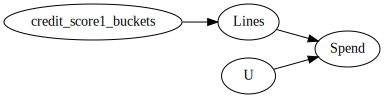

In [ ]:
g = gr.Digraph(graph_attr={"rankdir":"LR"})


g.edge("credit_score1_buckets", "Lines"),
g.edge("U", "Spend"),
g.edge("Lines", "Spend")

g

In [ ]:
spend_data_rnd = pd.read_csv("data/spend_data_rnd.csv")

model = smf.ols("spend ~ np.sqrt(credit_limit)",
                data=spend_data_rnd).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2153.2154,218.600,9.850,0.000,1723.723,2582.708
np.sqrt(credit_limit),16.2915,2.988,5.452,0.000,10.420,22.163


In [ ]:
model = smf.ols("spend~np.sqrt(credit_limit)+C(credit_score1_buckets)",
                data=spend_data_rnd).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2367.4867,556.273,4.256,0.000,1274.528,3460.446
C(credit_score1_buckets)[T.200],-144.7921,591.613,-0.245,0.807,-1307.185,1017.601
C(credit_score1_buckets)[T.400],-118.3923,565.364,-0.209,0.834,-1229.211,992.427
C(credit_score1_buckets)[T.600],-111.5738,570.471,-0.196,0.845,-1232.429,1009.281
C(credit_score1_buckets)[T.800],-89.7366,574.645,-0.156,0.876,-1218.791,1039.318
C(credit_score1_buckets)[T.1000],363.8990,608.014,0.599,0.550,-830.720,1558.518
np.sqrt(credit_limit),14.5953,3.523,4.142,0.000,7.673,21.518


### 4.9.2 특성 선택: 편향-분산 트레이드오프


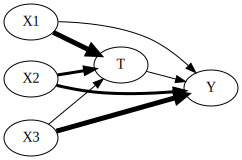

In [ ]:
g = gr.Digraph(graph_attr={"rankdir": "LR"})


g.edge("X1", "T", penwidth="5"),
g.edge("X2", "T", penwidth="3"),
g.edge("X3", "T", penwidth="1"),

g.edge("X1", "Y", penwidth="1"),
g.edge("X2", "Y", penwidth="3"),
g.edge("X3", "Y", penwidth="5"),

g.edge("T", "Y"),

g

In [ ]:
np.random.seed(123)

n = 100
(x1, x2, x3) = (np.random.normal(0, 1, n) for _ in range(3))
t = np.random.normal(10*x1 + 5*x2 + x3)

# ate = 0.05
y = np.random.normal(0.05*t + x1 + 5*x2 + 10*x3, 5)
df = pd.DataFrame(dict(y=y, t=t, x1=x1, x2=x2, x3=x3))

smf.ols("y~t+x1+x2+x3", data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2707,0.527,0.514,0.608,-0.775,1.316
t,0.8664,0.607,1.427,0.157,-0.339,2.072
x1,-7.0628,6.038,-1.170,0.245,-19.049,4.923
x2,0.0143,3.128,0.005,0.996,-6.195,6.224
x3,9.6292,0.887,10.861,0.000,7.869,11.389


In [ ]:
smf.ols("y~t+x2+x3", data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1889,0.523,0.361,0.719,-0.849,1.227
t,0.1585,0.046,3.410,0.001,0.066,0.251
x2,3.6095,0.582,6.197,0.000,2.453,4.766
x3,10.4549,0.537,19.453,0.000,9.388,11.522


## 4.10 요약


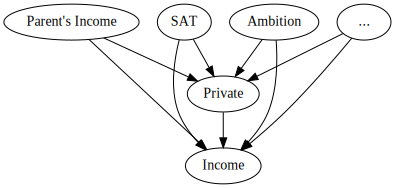

In [ ]:
import graphviz as gr

g = gr.Digraph(format="png")

g.edge("Parent's Income", "Private")
g.edge("SAT", "Private")
g.edge("Ambition", "Private")
g.edge("...", "Private")

g.edge("Parent's Income", "Income")
g.edge("SAT", "Income")
g.edge("Ambition", "Income")
g.edge("...", "Income")

g.edge("Private", "Income")

g